In [4]:
rm(list = ls())
setwd(rprojroot::find_rstudio_root_file())
#source("base/Charts.R")

In [5]:
plot_pheatmap_EDA <- function(
    filename_input,
    metric_variable,
    legend_title,
    filename_export,
    plot_absolute,
    threshold_for_x = 0.1
) {
  #https://jokergoo.github.io/2020/05/06/translate-from-pheatmap-to-complexheatmap/
  #https://jokergoo.github.io/ComplexHeatmap-reference/book/a-list-of-heatmaps.html
  
      #libraries
  suppressPackageStartupMessages(library(ComplexHeatmap))
  suppressPackageStartupMessages(library(data.table)) 
  suppressPackageStartupMessages(library(circlize))
  suppressPackageStartupMessages(library(lubridate))
  
  df <- readRDS(filename_input)
  setDT(df)
  
  # Split predictor_name into var, fun, and horizon_months
  df <- df[, c("var", "fun", "horizon_months") := tstrsplit(predictor_name, "_", fixed = TRUE)][]
  df <- df[, horizon_months := as.numeric(gsub("*months","",horizon_months))][]
  df <- df[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  # Create catchment_month and predictor columns
  df <- df[, catchment_month := paste(catchment_code, month_initialisation, sep = "_")][]
  df <- df[, predictor := paste(var, horizon_months, sep = "_")]
  df$predictor = factor(df$predictor,levels = unique(df$predictor))
  # Use dcast to reshape the data into a correlation matrix
  cor_matrix <-
    dcast(df,
          catchment_month ~ predictor,
          value.var = metric_variable,
          fill = NA,
          verbose = T)
  
  # Annotation for rows
  annotation_row <- data.table(catchment_month = cor_matrix[, catchment_month])
  annotation_row <-annotation_row[,
                                  c("catchment_code", "month_initialisation") := 
                                    tstrsplit(catchment_month, "_",
                                              fixed = TRUE, keep = 1:2)]
  #annotation_row$month_initialisation = lubridate::month(as.numeric(annotation_row$month_initialisation),label = T)
  annotation_row$month_initialisation = paste0('1° ',annotation_row$month_initialisation)
  
  annotation_row <- annotation_row[, catchment_code := as.numeric(catchment_code)]
  annotation_row <- annotation_row[, month_initialisation := factor(
    x = month_initialisation,
    levels = (paste0('1° ',levels(df$month_initialisation) )))]
  annotation_row <- tibble::column_to_rownames(annotation_row, var = "catchment_month")
  rows_split <-  annotation_row$month_initialisation
  annotation_row$month_initialisation <- NULL
  
  # Annotation for columns
  cor_matrix$catchment_month <- NULL
  cor_matrix <- as.matrix(cor_matrix)
  annotation_col <- data.table(predictor = colnames(cor_matrix))
  annotation_col <- annotation_col[, c("var", "horizon_months") := tstrsplit(predictor, "_", fixed = TRUE, keep = 1:2)]
  annotation_col <- annotation_col[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  annotation_col <- annotation_col[, var := factor(var)]
  #setkeyv(annotation_col,c("var", "horizon_months"))
  
  
  cols_split <-  annotation_col$var
  annotation_col$var <-  NULL # remove var from legend
  annotation_col$predictor <- NULL # remove predictor from legend
  colnames(cor_matrix) <- NULL #remove row labels
  
 
  
  #### colors
  length_horizon = length(unique(as.numeric(annotation_col$horizon_months)) )
  colours_blue <- colorRampPalette(c("#190E53", "#3C3176", "#887FBC"))(length_horizon)
  
  
  col_fun = colorRamp2(c(-1,-0.5, 0,0.5, 1), c("red","orange", "white","skyblue", "blue"))
  
  ann_colors = list(
    catchment_code = c("firebrick", 'green'),
    horizon_months = setNames(colours_blue, unique(annotation_col$horizon_months))
  )

  
  #library(RColorBrewer)
  #Plot correlation matrix and absolute correlation matrix using pheatmap
  p = 
    pheatmap((cor_matrix),
             cluster_row = F,
             cluster_cols = F,
             color = col_fun,#colorRampPalette((brewer.pal(n = 7, name = "RdBu")))(100),
             annotation_row = annotation_row,
             annotation_col = annotation_col,
             
             row_split = rows_split,
             column_split = cols_split,
             annotation_names_col = F,
             annotation_names_row = F,
             annotation_colors = ann_colors,
             heatmap_legend_param = list(
               at = c(-1, 0, 1),
               title = legend_title,
               legend_height = unit(3, "cm"),
               title_position = "topleft"
             ),
             cell_fun = function(j, i, x, y, width, height, fill) {
               if (cor_matrix[i, j] > -threshold_for_x &
                   cor_matrix[i, j] < threshold_for_x)
                 grid.text('x', x, y, gp = gpar(fontsize = 6))
             }
    )
  #export in png format
  filename_export_png = paste0(
    "data_output/scores/figures/",
    filename_export,
    today(),
    ".png"
  )
  
  png(
    filename = filename_export_png,
    width = 10,
    height = 10,
    units = "in",
    res = 800
  )
  p_draw =
    draw(p,
       merge_legend = TRUE,
       column_title = paste0(legend_title, ": predictores vs volumen sep-mar, 1981-2021. Reg. Lineal"),
       row_title = "Fecha de emisión",
       column_title_gp = gpar(fontsize = 15),
       ht_gap = unit(4, "cm"))
  
  dev.off()
  
plot_list = list(plot1 = p_draw, filename1 = filename_export_png )
  #### absolute value
  
  return(plot_list)
}

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


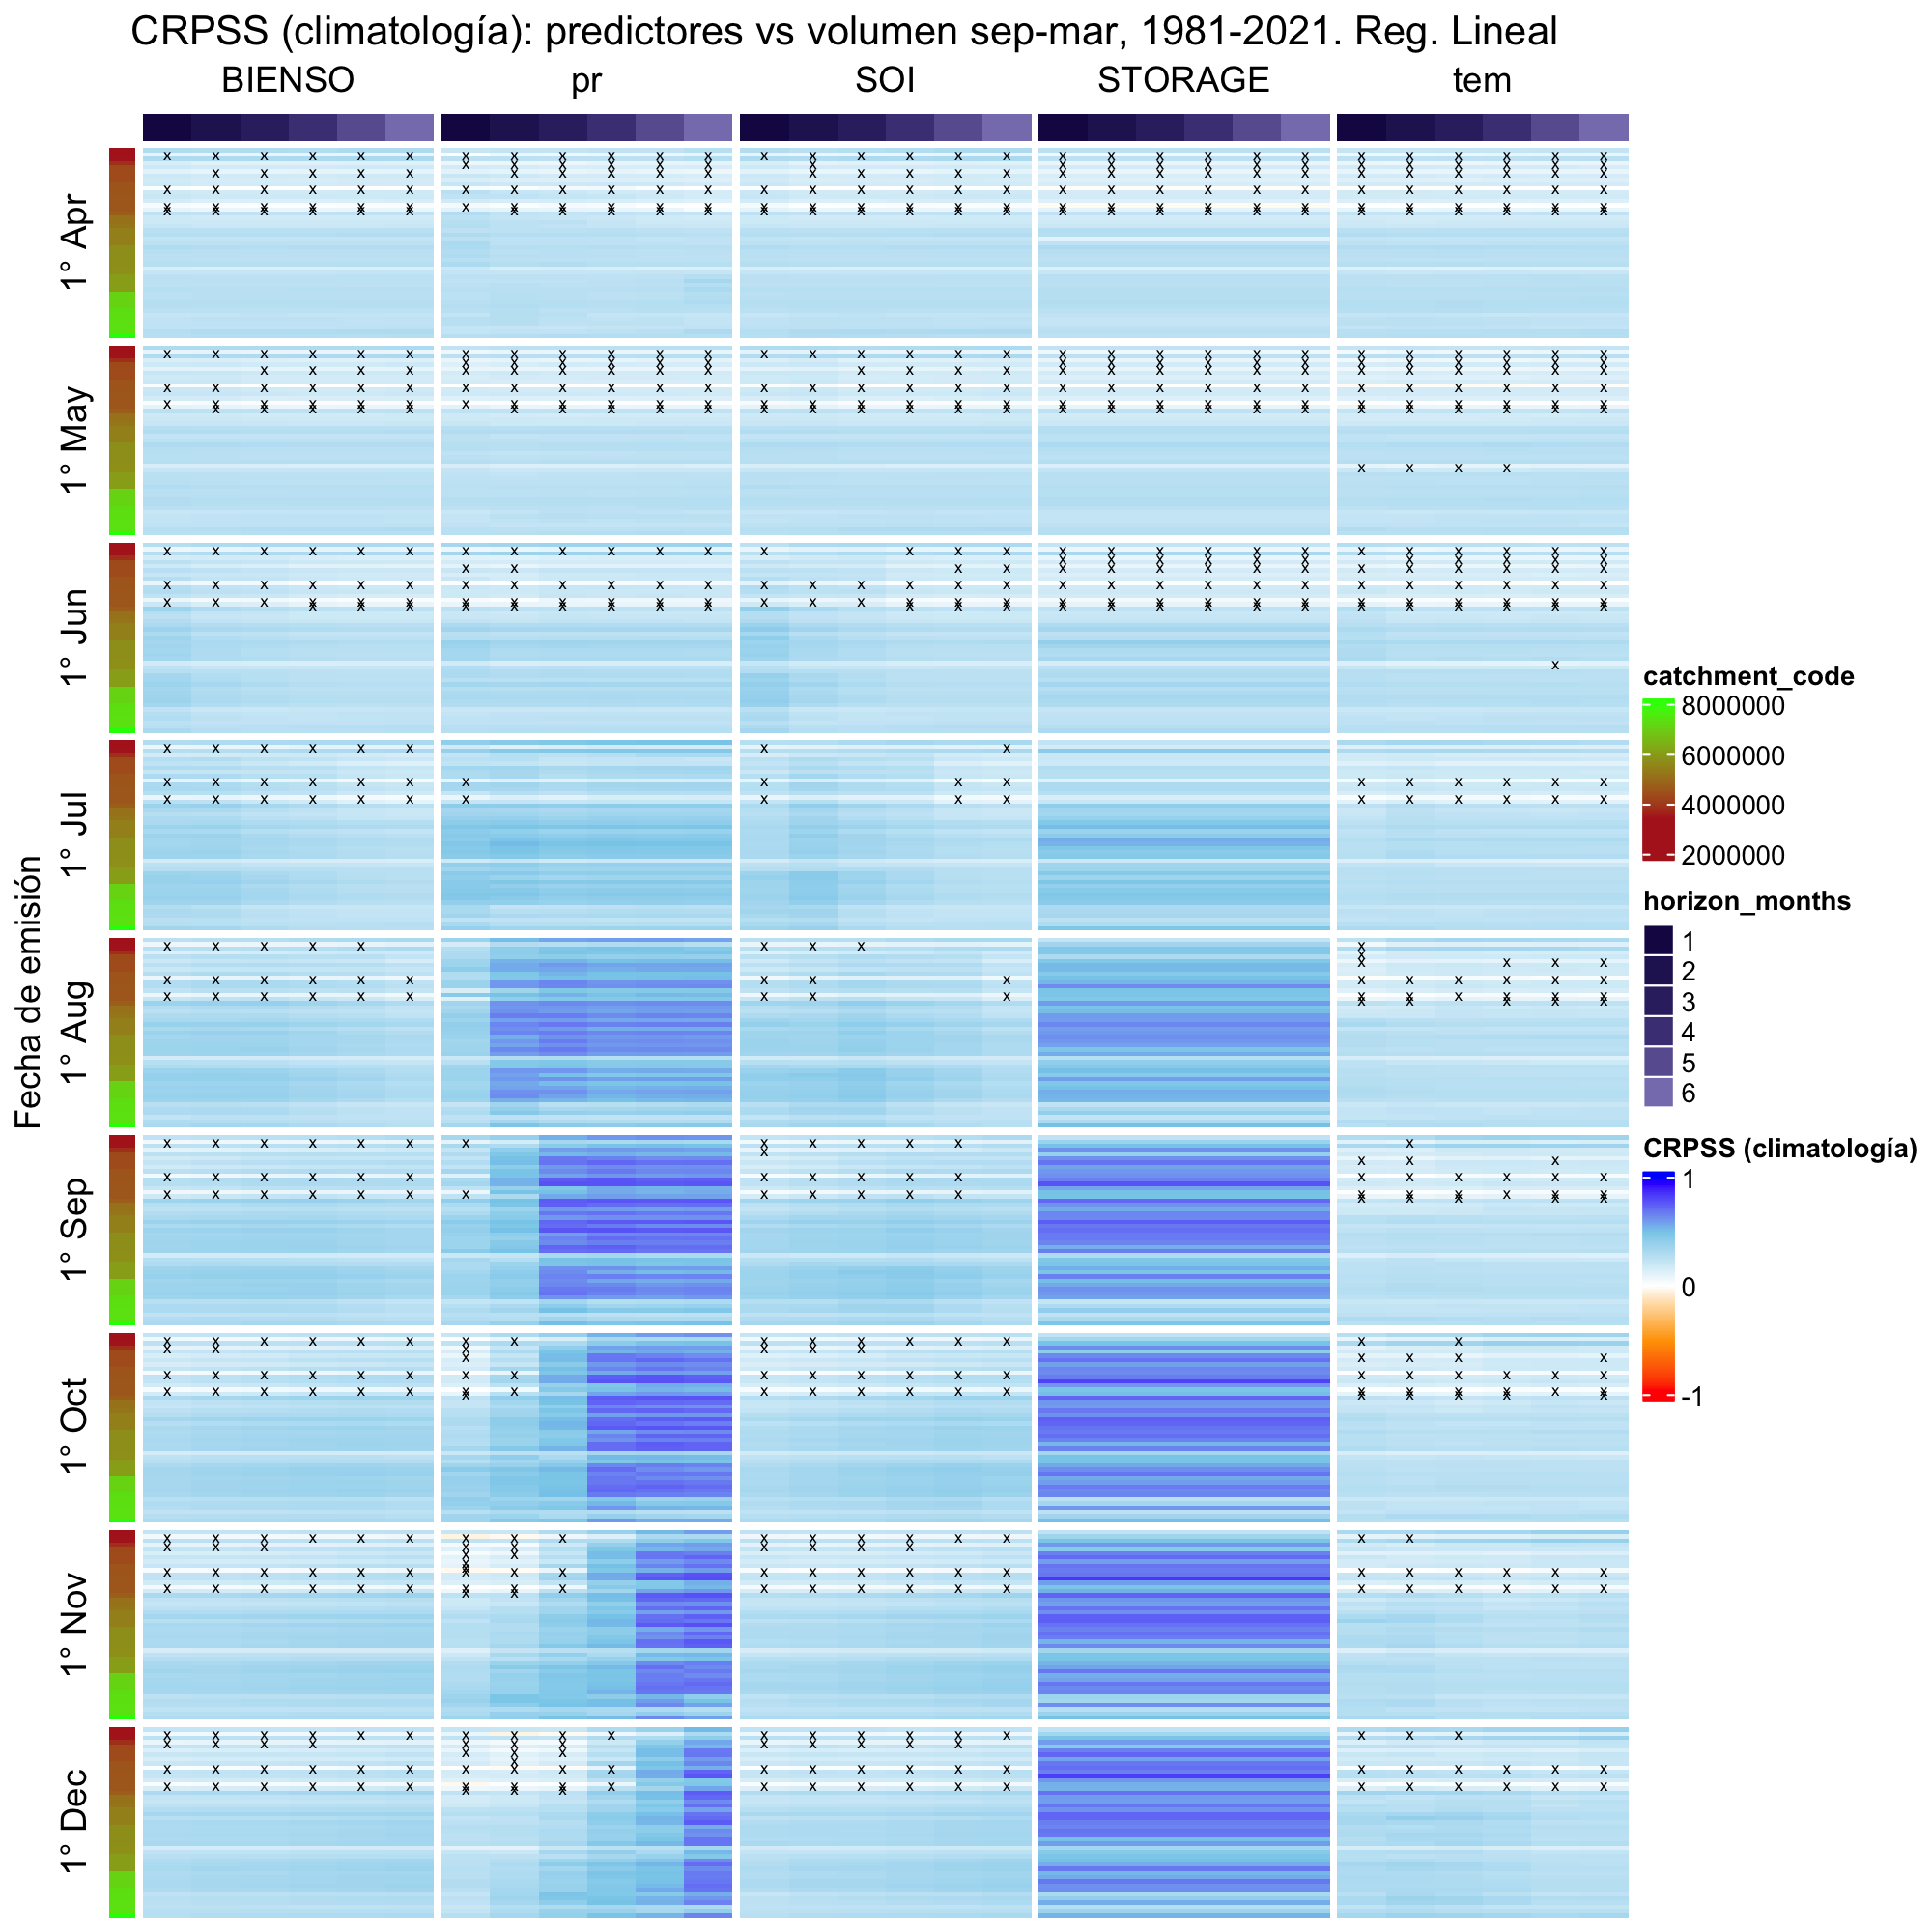

In [6]:
CRPSS_plot = list(
    filename_input  = "data_output/scores/RDS/model_results_singles_2023-03-13.RDS",
  metric_variable = "crpss_climatology",
  filename_export = "CRPSS_vol_indicator_pheatmap",
  legend_title = "CRPSS (climatología)",
  plot_absolute = F
)

plot = do.call(plot_pheatmap_EDA,CRPSS_plot)
options(repr.plot.width = 10, repr.plot.height = 10,repr.plot.res = 200)
plot$plot1

In [7]:
plot_pheatmap_EDA2 <- function(
    filename_input,
    metric_variable,
    legend_title,
    filename_export,
    plot_absolute,
    sub_variable,
    threshold_for_x = 0.1
) {
  #https://jokergoo.github.io/2020/05/06/translate-from-pheatmap-to-complexheatmap/
  #https://jokergoo.github.io/ComplexHeatmap-reference/book/a-list-of-heatmaps.html
  
      #libraries
  suppressPackageStartupMessages(library(ComplexHeatmap))
  suppressPackageStartupMessages(library(data.table)) 
  suppressPackageStartupMessages(library(circlize))
  suppressPackageStartupMessages(library(lubridate))
  
  df <- readRDS(filename_input)
  setDT(df)
  
  # Split predictor_name into var, fun, and horizon_months
  df <- df[, c("var", "fun", "horizon_months") := tstrsplit(predictor_name, "_", fixed = TRUE)][]
  df <- df[, horizon_months := as.numeric(gsub("*months","",horizon_months))][]
  df <- df[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  # Create catchment_month and predictor columns
  df <- df[, catchment_month := paste(catchment_code, month_initialisation, sep = "_")][]
  df <- df[, predictor := paste(var,method, horizon_months, sep = "_")]
  df$predictor = factor(df$predictor,levels = unique(df$predictor))
  df = subset(df,var==sub_variable)
  # Use dcast to reshape the data into a correlation matrix
  cor_matrix <-
    dcast(df,
          catchment_month ~ predictor,
          value.var = metric_variable,
          fill = NA,
          verbose = T)
  
  # Annotation for rows
  annotation_row <- data.table(catchment_month = cor_matrix[, catchment_month])
  annotation_row <-annotation_row[,
                                  c("catchment_code", "month_initialisation") := 
                                    tstrsplit(catchment_month, "_",
                                              fixed = TRUE, keep = 1:2)]
  #annotation_row$month_initialisation = lubridate::month(as.numeric(annotation_row$month_initialisation),label = T)
  annotation_row$month_initialisation = paste0('1° ',annotation_row$month_initialisation)
  
  annotation_row <- annotation_row[, catchment_code := as.numeric(catchment_code)]
  annotation_row <- annotation_row[, month_initialisation := factor(
    x = month_initialisation,
    levels = (paste0('1° ',levels(df$month_initialisation) )))]
  annotation_row <- tibble::column_to_rownames(annotation_row, var = "catchment_month")
  rows_split <-  annotation_row$month_initialisation
  annotation_row$month_initialisation <- NULL
  
  # Annotation for columns
  cor_matrix$catchment_month <- NULL
  cor_matrix <- as.matrix(cor_matrix)
  annotation_col <- data.table(predictor = colnames(cor_matrix))
  annotation_col <- annotation_col[, c("var","method", "horizon_months") := tstrsplit(predictor, "_", fixed = TRUE, keep = 1:3)]
  annotation_col <- annotation_col[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  annotation_col <- annotation_col[, var := factor(var)]
  #setkeyv(annotation_col,c("var", "horizon_months"))
  
  
  cols_split <-  annotation_col$method
  annotation_col$var <-  NULL # remove var from legend
  annotation_col$predictor <- NULL # remove predictor from legend
  colnames(cor_matrix) <- NULL #remove row labels
  
  
  
  #### colors
  length_horizon = length(unique(as.numeric(annotation_col$horizon_months)) )
  colours_blue <- colorRampPalette(c("#190E53", "#3C3176", "#887FBC"))(length_horizon)
  
  
  col_fun = colorRamp2(c(-1,-0.5, 0,0.5, 1), c("red","orange", "white","skyblue", "blue"))
  
  ann_colors = list(
    catchment_code = c("firebrick", 'green'),
    horizon_months = setNames(colours_blue, unique(annotation_col$horizon_months))
  )
  
  
  #library(RColorBrewer)
  #Plot correlation matrix and absolute correlation matrix using pheatmap
  p = 
    pheatmap((cor_matrix),
             cluster_row = F,
             cluster_cols = F,
             color = col_fun,#colorRampPalette((brewer.pal(n = 7, name = "RdBu")))(100),
             annotation_row = annotation_row,
             annotation_col = annotation_col,
             
             row_split = rows_split,
             column_split = cols_split,
             annotation_names_col = F,
             annotation_names_row = F,
             annotation_colors = ann_colors,
             heatmap_legend_param = list(
               at = c(-1, 0, 1),
               title = legend_title,
               legend_height = unit(3, "cm"),
               title_position = "topleft"
             ),
             cell_fun = function(j, i, x, y, width, height, fill) {
               if (cor_matrix[i, j] > -threshold_for_x &
                   cor_matrix[i, j] < threshold_for_x)
                 grid.text('x', x, y, gp = gpar(fontsize = 6))
             }
    )
  #export in png format
  filename_export_png = paste0(
    "data_output/scores/figures/",
    filename_export,
    today(),
    ".png"
  )
  
  png(
    filename = filename_export_png,
    width = 10,
    height = 10,
    units = "in",
    res = 800
  )
  p_draw =
    draw(p,
         merge_legend = TRUE,
         column_title = paste0(legend_title, ": ",sub_variable," vs volumen sep-mar, 1981-2021"),
         row_title = "Fecha de emisión",
         column_title_gp = gpar(fontsize = 15),
         ht_gap = unit(4, "cm"))
  
  dev.off()
  
  plot_list = list(plot1 = p_draw, filename1 = filename_export_png )
  
  return(plot_list)
}


Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


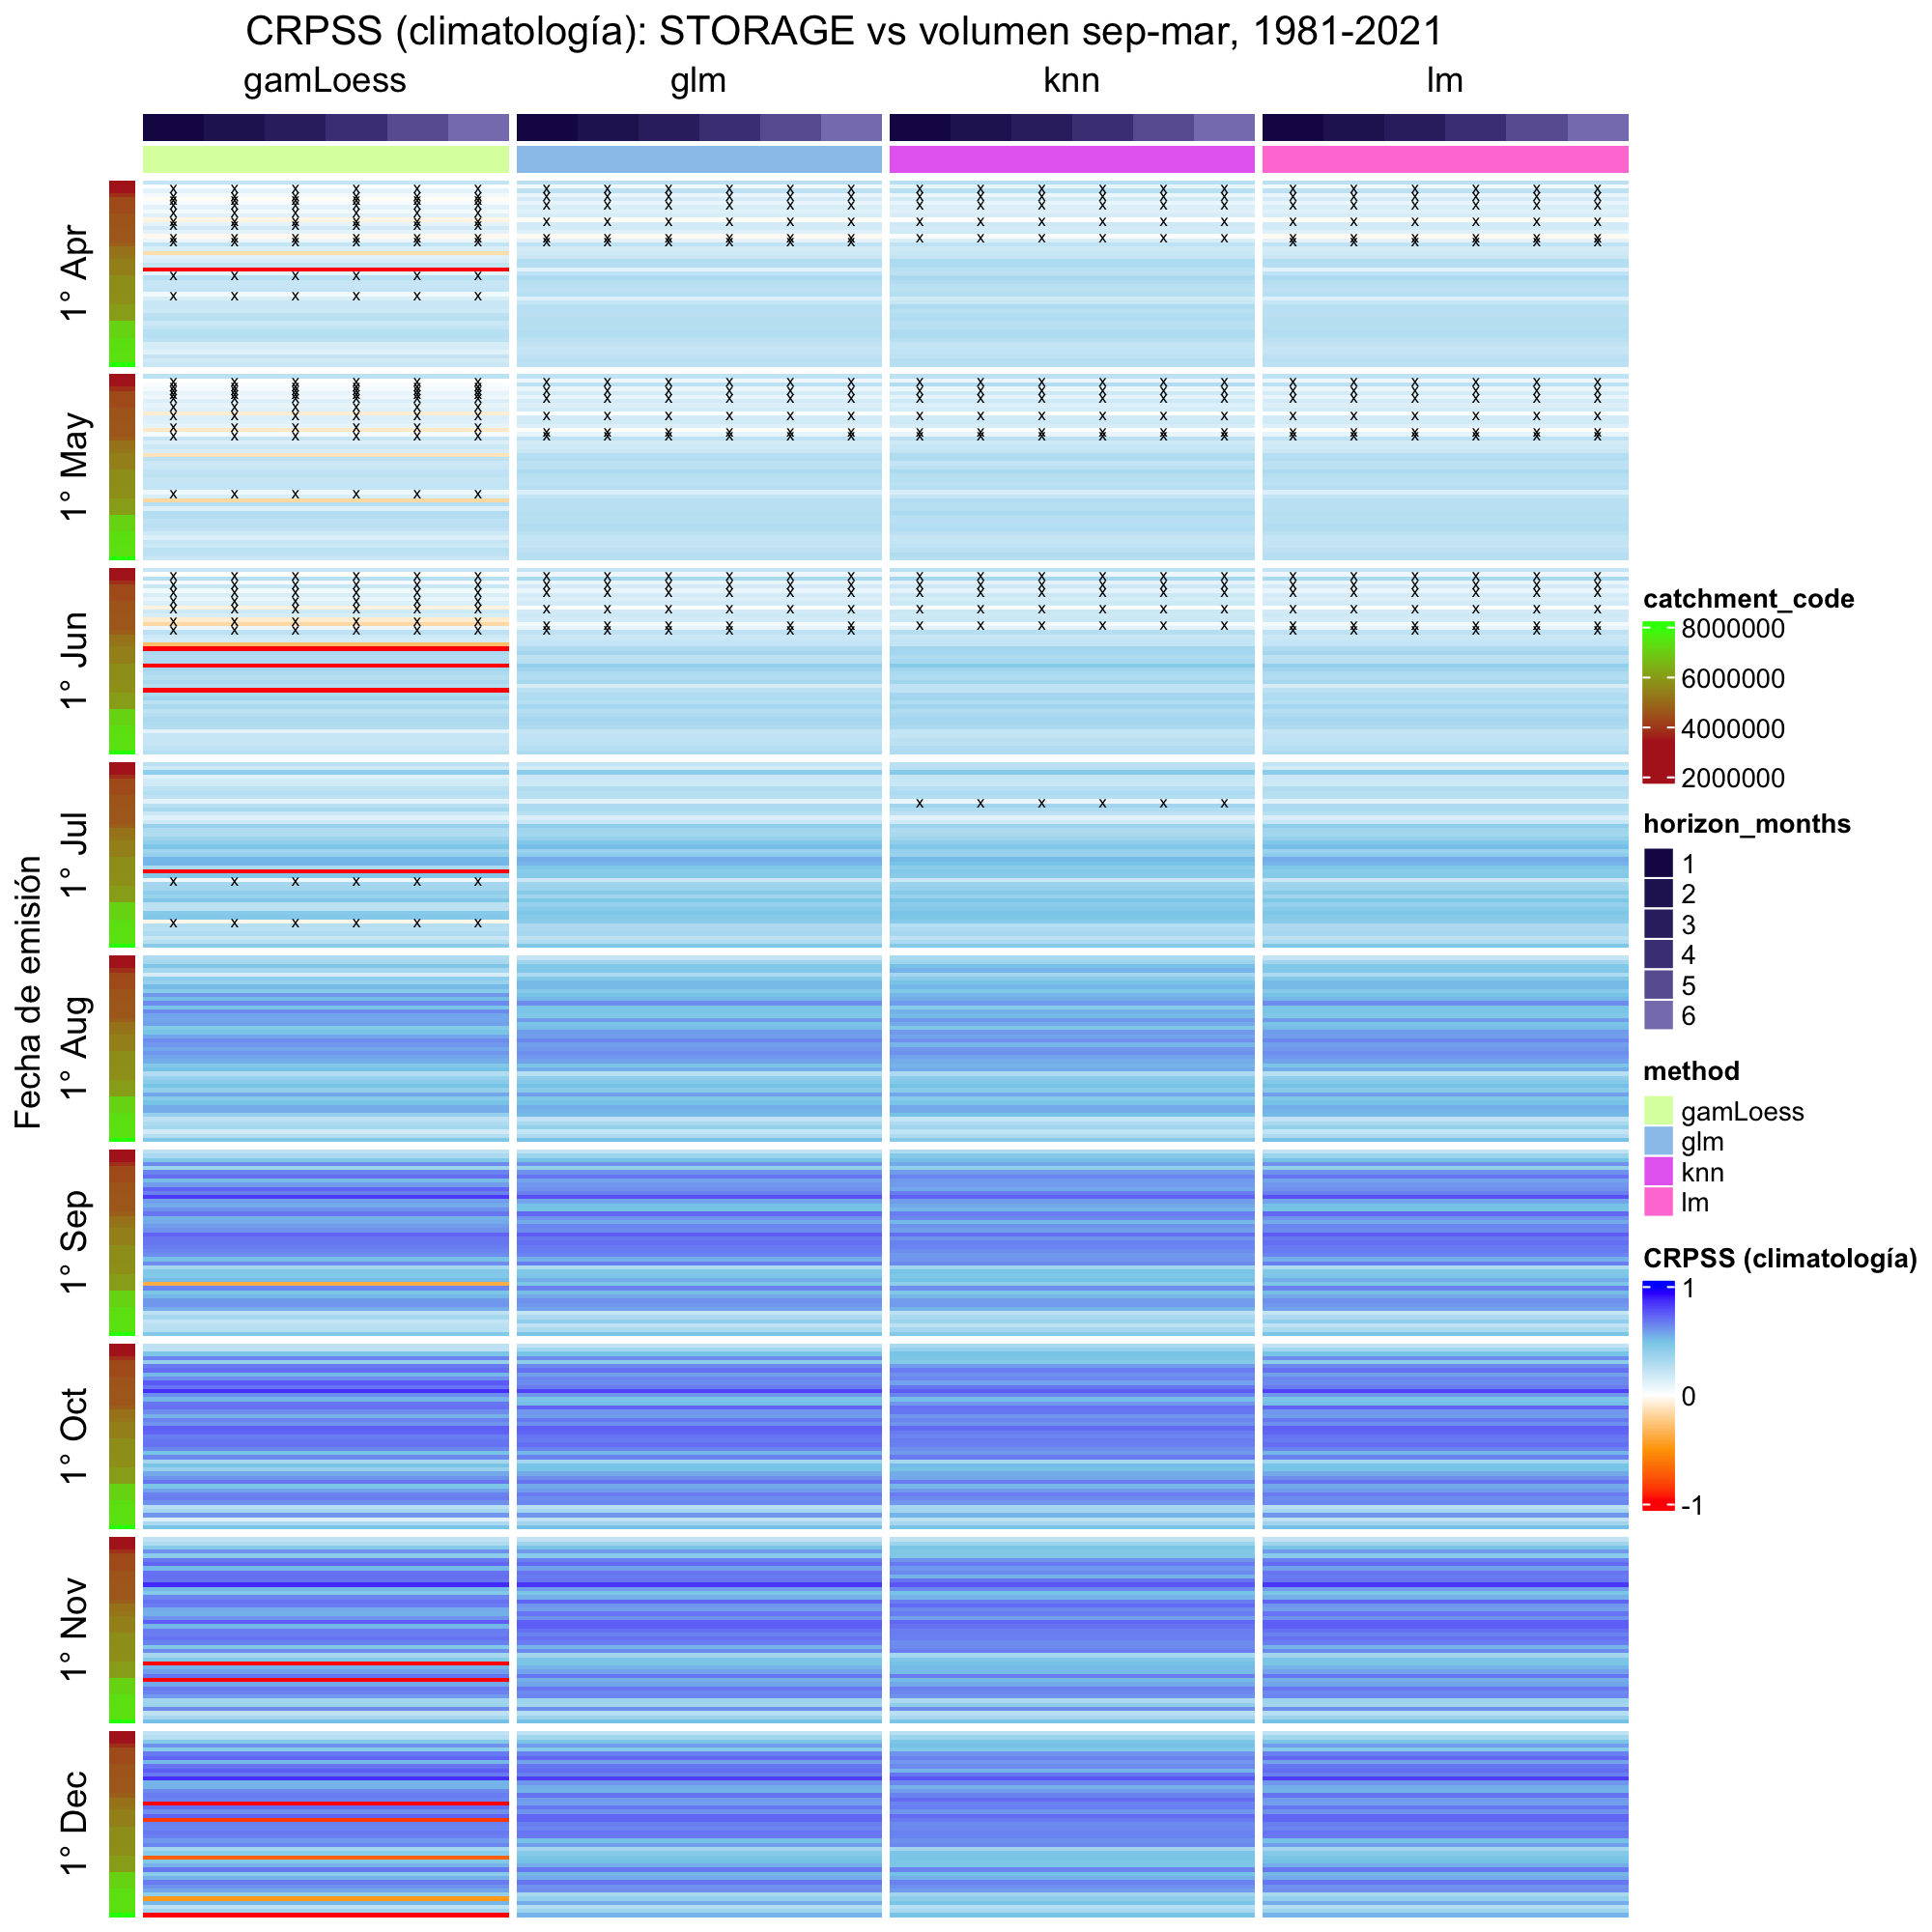

In [8]:
CRPSS_plot = list(
    filename_input  = "data_output/scores/RDS/model_results_singles_models_2023-03-14.RDS",
  metric_variable = "crpss_climatology",
  filename_export = "CRPSS_vol_indicator_pheatmap",
  legend_title = "CRPSS (climatología)",
    sub_variable = "STORAGE",
  plot_absolute = F
)

plot = do.call(plot_pheatmap_EDA2,CRPSS_plot)
options(repr.plot.width = 10, repr.plot.height = 10,repr.plot.res = 200)
plot$plot1

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


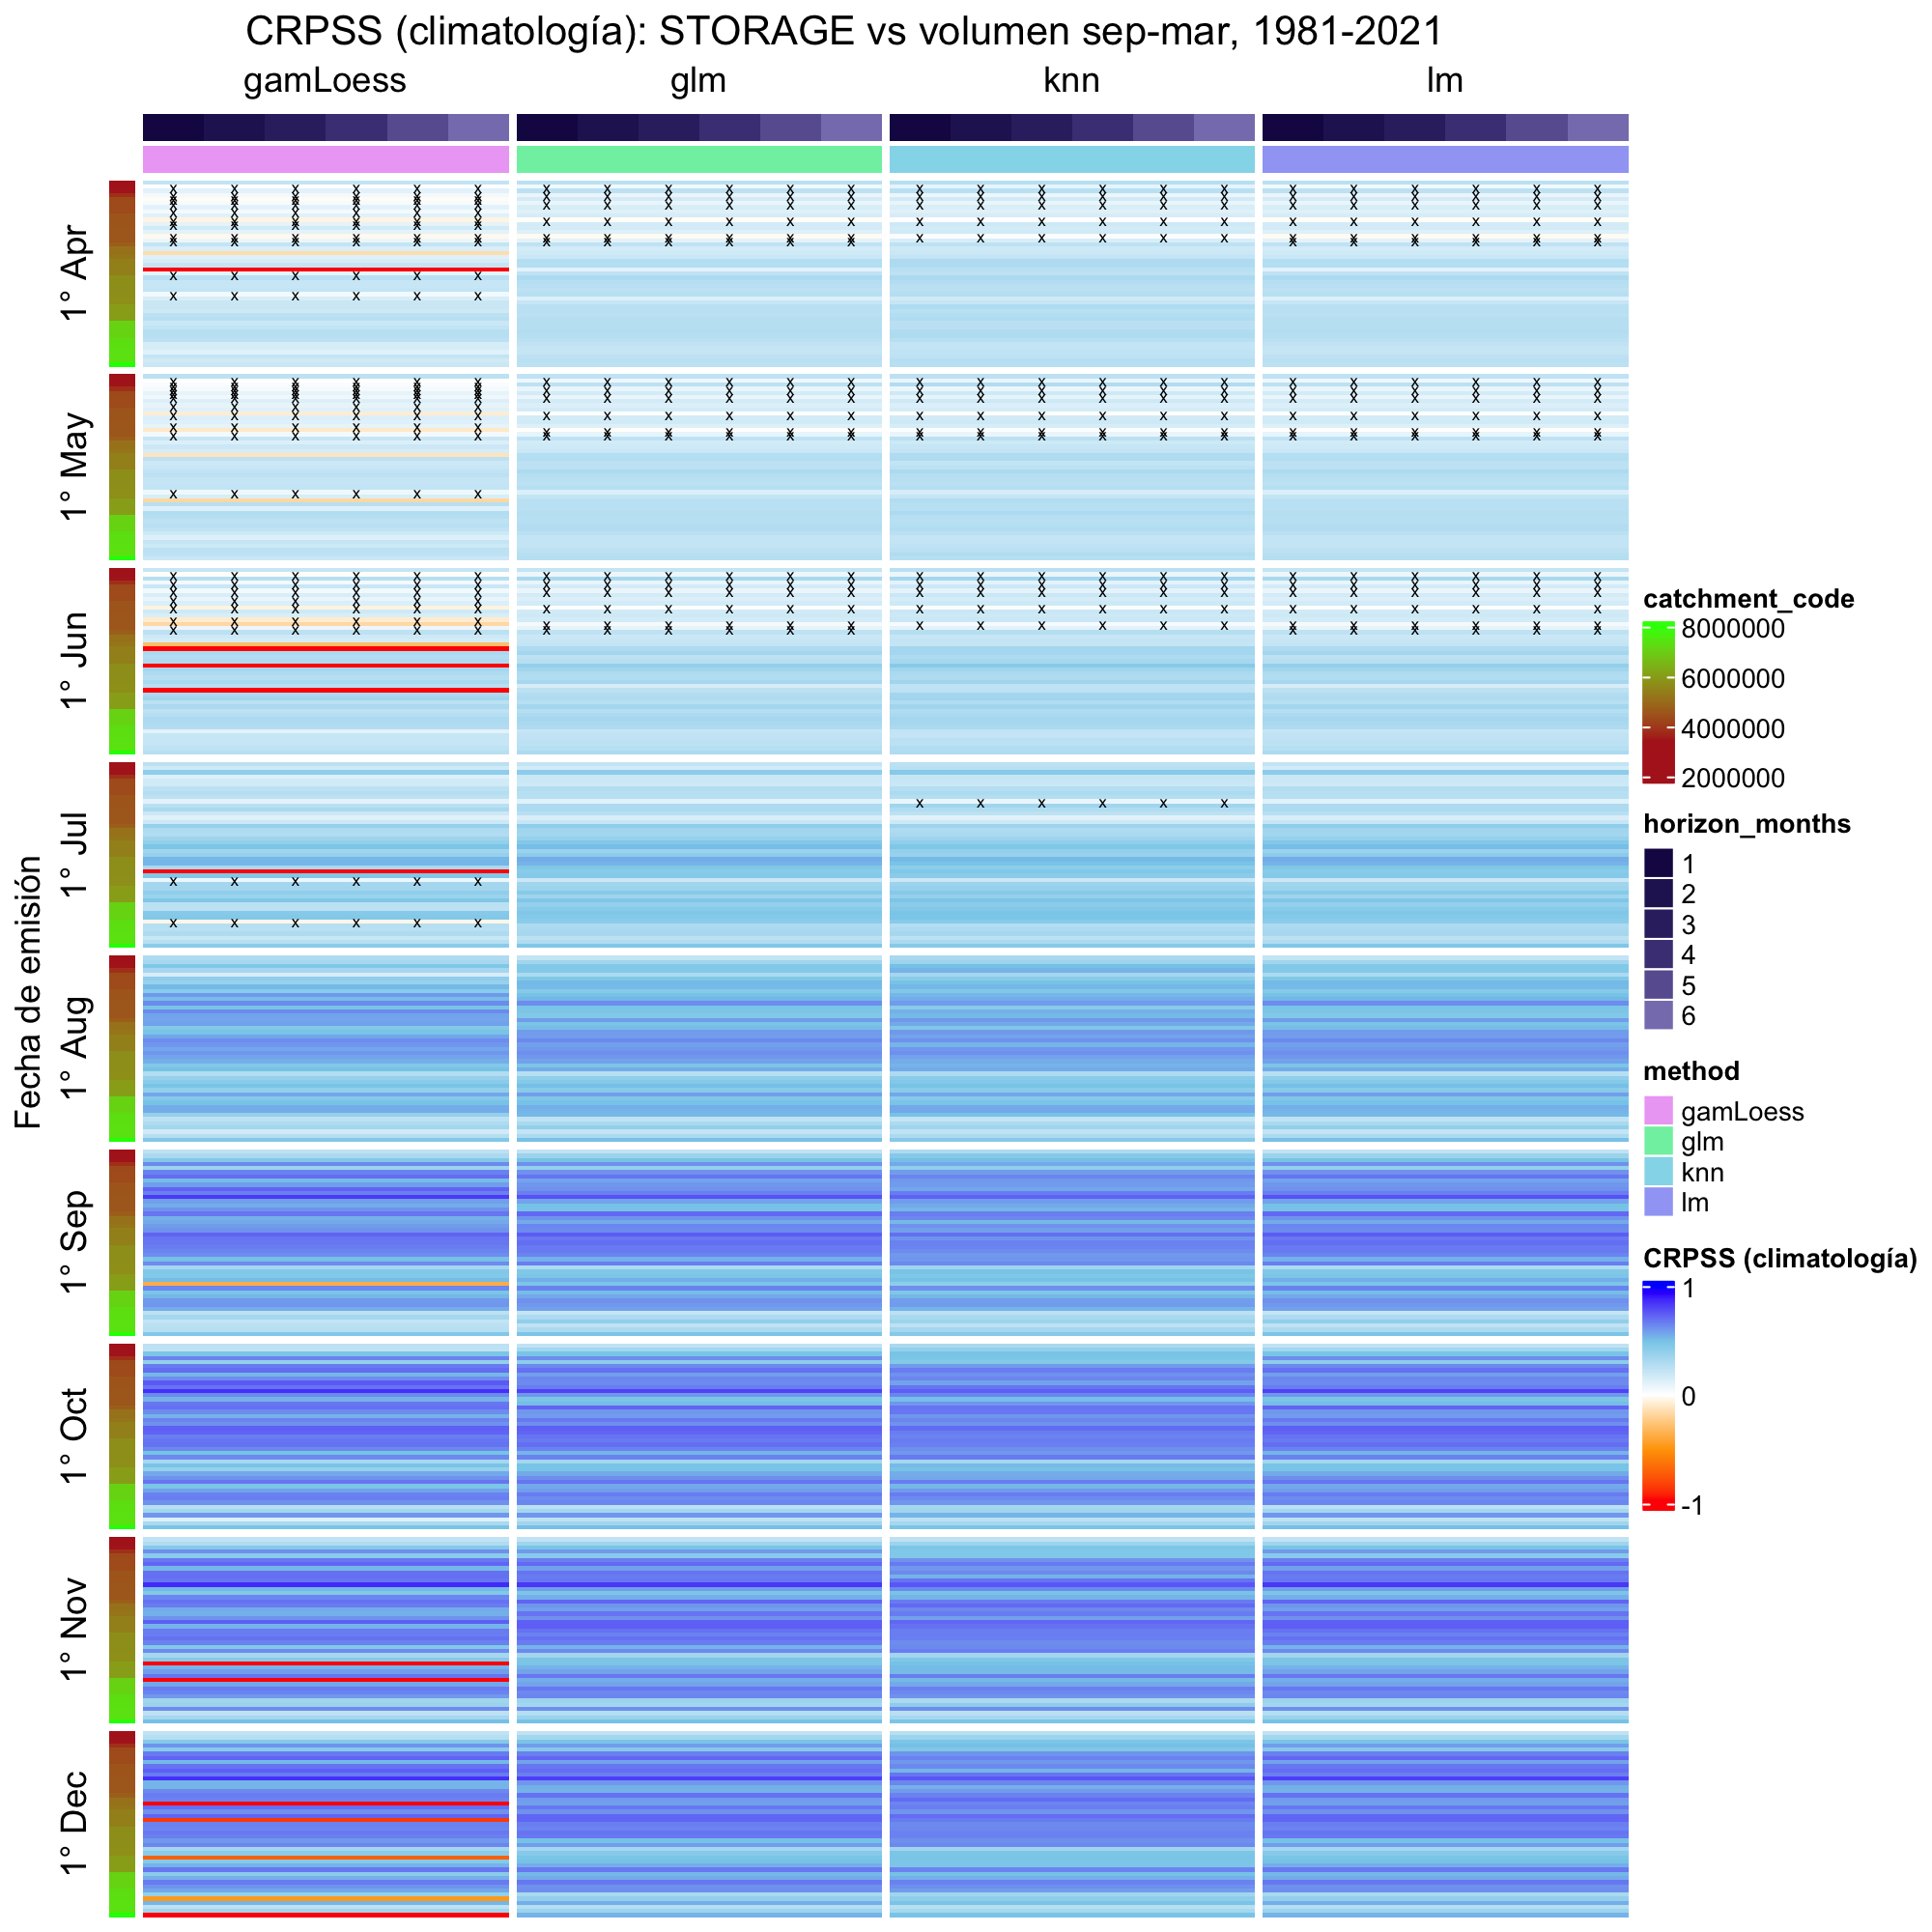

In [9]:
CRPSS_plot = list(
    filename_input  = "data_output/scores/RDS/model_results_singles_models_2023-03-14.RDS",
  metric_variable = "crpss_climatology",
  filename_export = "CRPSS_vol_indicator_pheatmap",
  legend_title = "CRPSS (climatología)",
    sub_variable = "STORAGE",
  plot_absolute = F
)

plot = do.call(plot_pheatmap_EDA2,CRPSS_plot)
options(repr.plot.width = 10, repr.plot.height = 10,repr.plot.res = 200)
plot$plot1

In [10]:
plot_pheatmap_EDA3 <- function(
    filename_input,
    metric_variable,
    legend_title,
    filename_export,
    plot_absolute,
    sub_month,
    threshold_for_x = 0.1
) {
  #https://jokergoo.github.io/2020/05/06/translate-from-pheatmap-to-complexheatmap/
  #https://jokergoo.github.io/ComplexHeatmap-reference/book/a-list-of-heatmaps.html
  
  #libraries
  suppressPackageStartupMessages(library(ComplexHeatmap))
  suppressPackageStartupMessages(library(data.table)) 
  suppressPackageStartupMessages(library(circlize))
  suppressPackageStartupMessages(library(lubridate))
  
  df <- readRDS(filename_input)
  setDT(df)
  
  # Split predictor_name into var, fun, and horizon_months
  df <- df[, c("var", "fun", "horizon_months") := tstrsplit(predictor_name, "_", fixed = TRUE)][]
  df <- df[, horizon_months := as.numeric(gsub("*months","",horizon_months))][]
  df <- df[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  
  # Create catchment_month and predictor columns
  df <- df[, catchment_month := paste(catchment_code, var, sep = "_")][]
  df <- df[, predictor := paste(method, horizon_months, sep = "_")]
  df$predictor = factor(df$predictor,levels = unique(df$predictor))
  df = subset(df,month_initialisation == sub_month)
  # Use dcast to reshape the data into a correlation matrix
  cor_matrix <-
    dcast(df,
          catchment_month ~ predictor,
          value.var = metric_variable,
          fill = NA,
          verbose = T)
  
  # Annotation for rows
  annotation_row <- data.table(catchment_month = cor_matrix[, catchment_month])
  annotation_row <-annotation_row[,
                                  c("catchment_code", "var") := 
                                    tstrsplit(catchment_month, "_",
                                              fixed = TRUE, keep = 1:2)]
  #annotation_row$month_initialisation = lubridate::month(as.numeric(annotation_row$month_initialisation),label = T)
  #annotation_row$month_initialisation = paste0('1° ',annotation_row$month_initialisation)
  
  annotation_row <- annotation_row[, catchment_code := as.numeric(catchment_code)]
  annotation_row <- tibble::column_to_rownames(annotation_row, var = "catchment_month")
  rows_split <-  annotation_row$var
  annotation_row$var <- NULL
  
  # Annotation for columns
  cor_matrix$catchment_month <- NULL
  cor_matrix <- as.matrix(cor_matrix)
  annotation_col <- data.table(predictor = colnames(cor_matrix))
  annotation_col <- annotation_col[, c("method", "horizon_months") := tstrsplit(predictor, "_", fixed = TRUE, keep = 1:2)]
  annotation_col <- annotation_col[, horizon_months := factor(horizon_months,levels = seq(1,12,1))]
  #annotation_col <- annotation_col[, var := factor(var)]
  #setkeyv(annotation_col,c("var", "horizon_months"))
  
  
  cols_split <-  annotation_col$method
  #annotation_col$var <-  NULL # remove var from legend
  annotation_col$predictor <- NULL # remove predictor from legend
  colnames(cor_matrix) <- NULL #remove row labels
  
  
  
  #### colors
  length_horizon = length(unique(as.numeric(annotation_col$horizon_months)) )
  colours_blue <- colorRampPalette(c("#190E53", "#3C3176", "#887FBC"))(length_horizon)
  
  
  col_fun = colorRamp2(c(-1,-0.5, 0,0.5, 1), c("red","orange", "white","skyblue", "blue"))
  
  ann_colors = list(
    catchment_code = c("firebrick", 'green'),
    horizon_months = setNames(colours_blue, unique(annotation_col$horizon_months))
  )
  
  
  #library(RColorBrewer)
  #Plot correlation matrix and absolute correlation matrix using pheatmap
  p = 
    pheatmap((cor_matrix),
             cluster_row = F,
             cluster_cols = F,
             color = col_fun,#colorRampPalette((brewer.pal(n = 7, name = "RdBu")))(100),
             annotation_row = annotation_row,
             annotation_col = annotation_col,
             
             row_split = rows_split,
             column_split = cols_split,
             annotation_names_col = F,
             annotation_names_row = F,
             annotation_colors = ann_colors,
             heatmap_legend_param = list(
               at = c(-1, 0, 1),
               title = legend_title,
               legend_height = unit(3, "cm"),
               title_position = "topleft"
             ),
             cell_fun = function(j, i, x, y, width, height, fill) {
               if (cor_matrix[i, j] > -threshold_for_x &
                   cor_matrix[i, j] < threshold_for_x)
                 grid.text('x', x, y, gp = gpar(fontsize = 6))
             }
    )
  #export in png format
  filename_export_png = paste0(
    "data_output/scores/figures/",
    filename_export,
    today(),
    ".png"
  )
  
  png(
    filename = filename_export_png,
    width = 10,
    height = 10,
    units = "in",
    res = 800
  )
  p_draw =
    draw(p,
         merge_legend = TRUE,
         column_title = paste0(legend_title, ": ",sub_month," vs volumen sep-mar, 1981-2021"),
         row_title = "Fecha de emisión",
         column_title_gp = gpar(fontsize = 15),
         ht_gap = unit(4, "cm"))
  
  dev.off()
  
  plot_list = list(plot1 = p_draw, filename1 = filename_export_png )
  
  return(plot_list)
}


Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


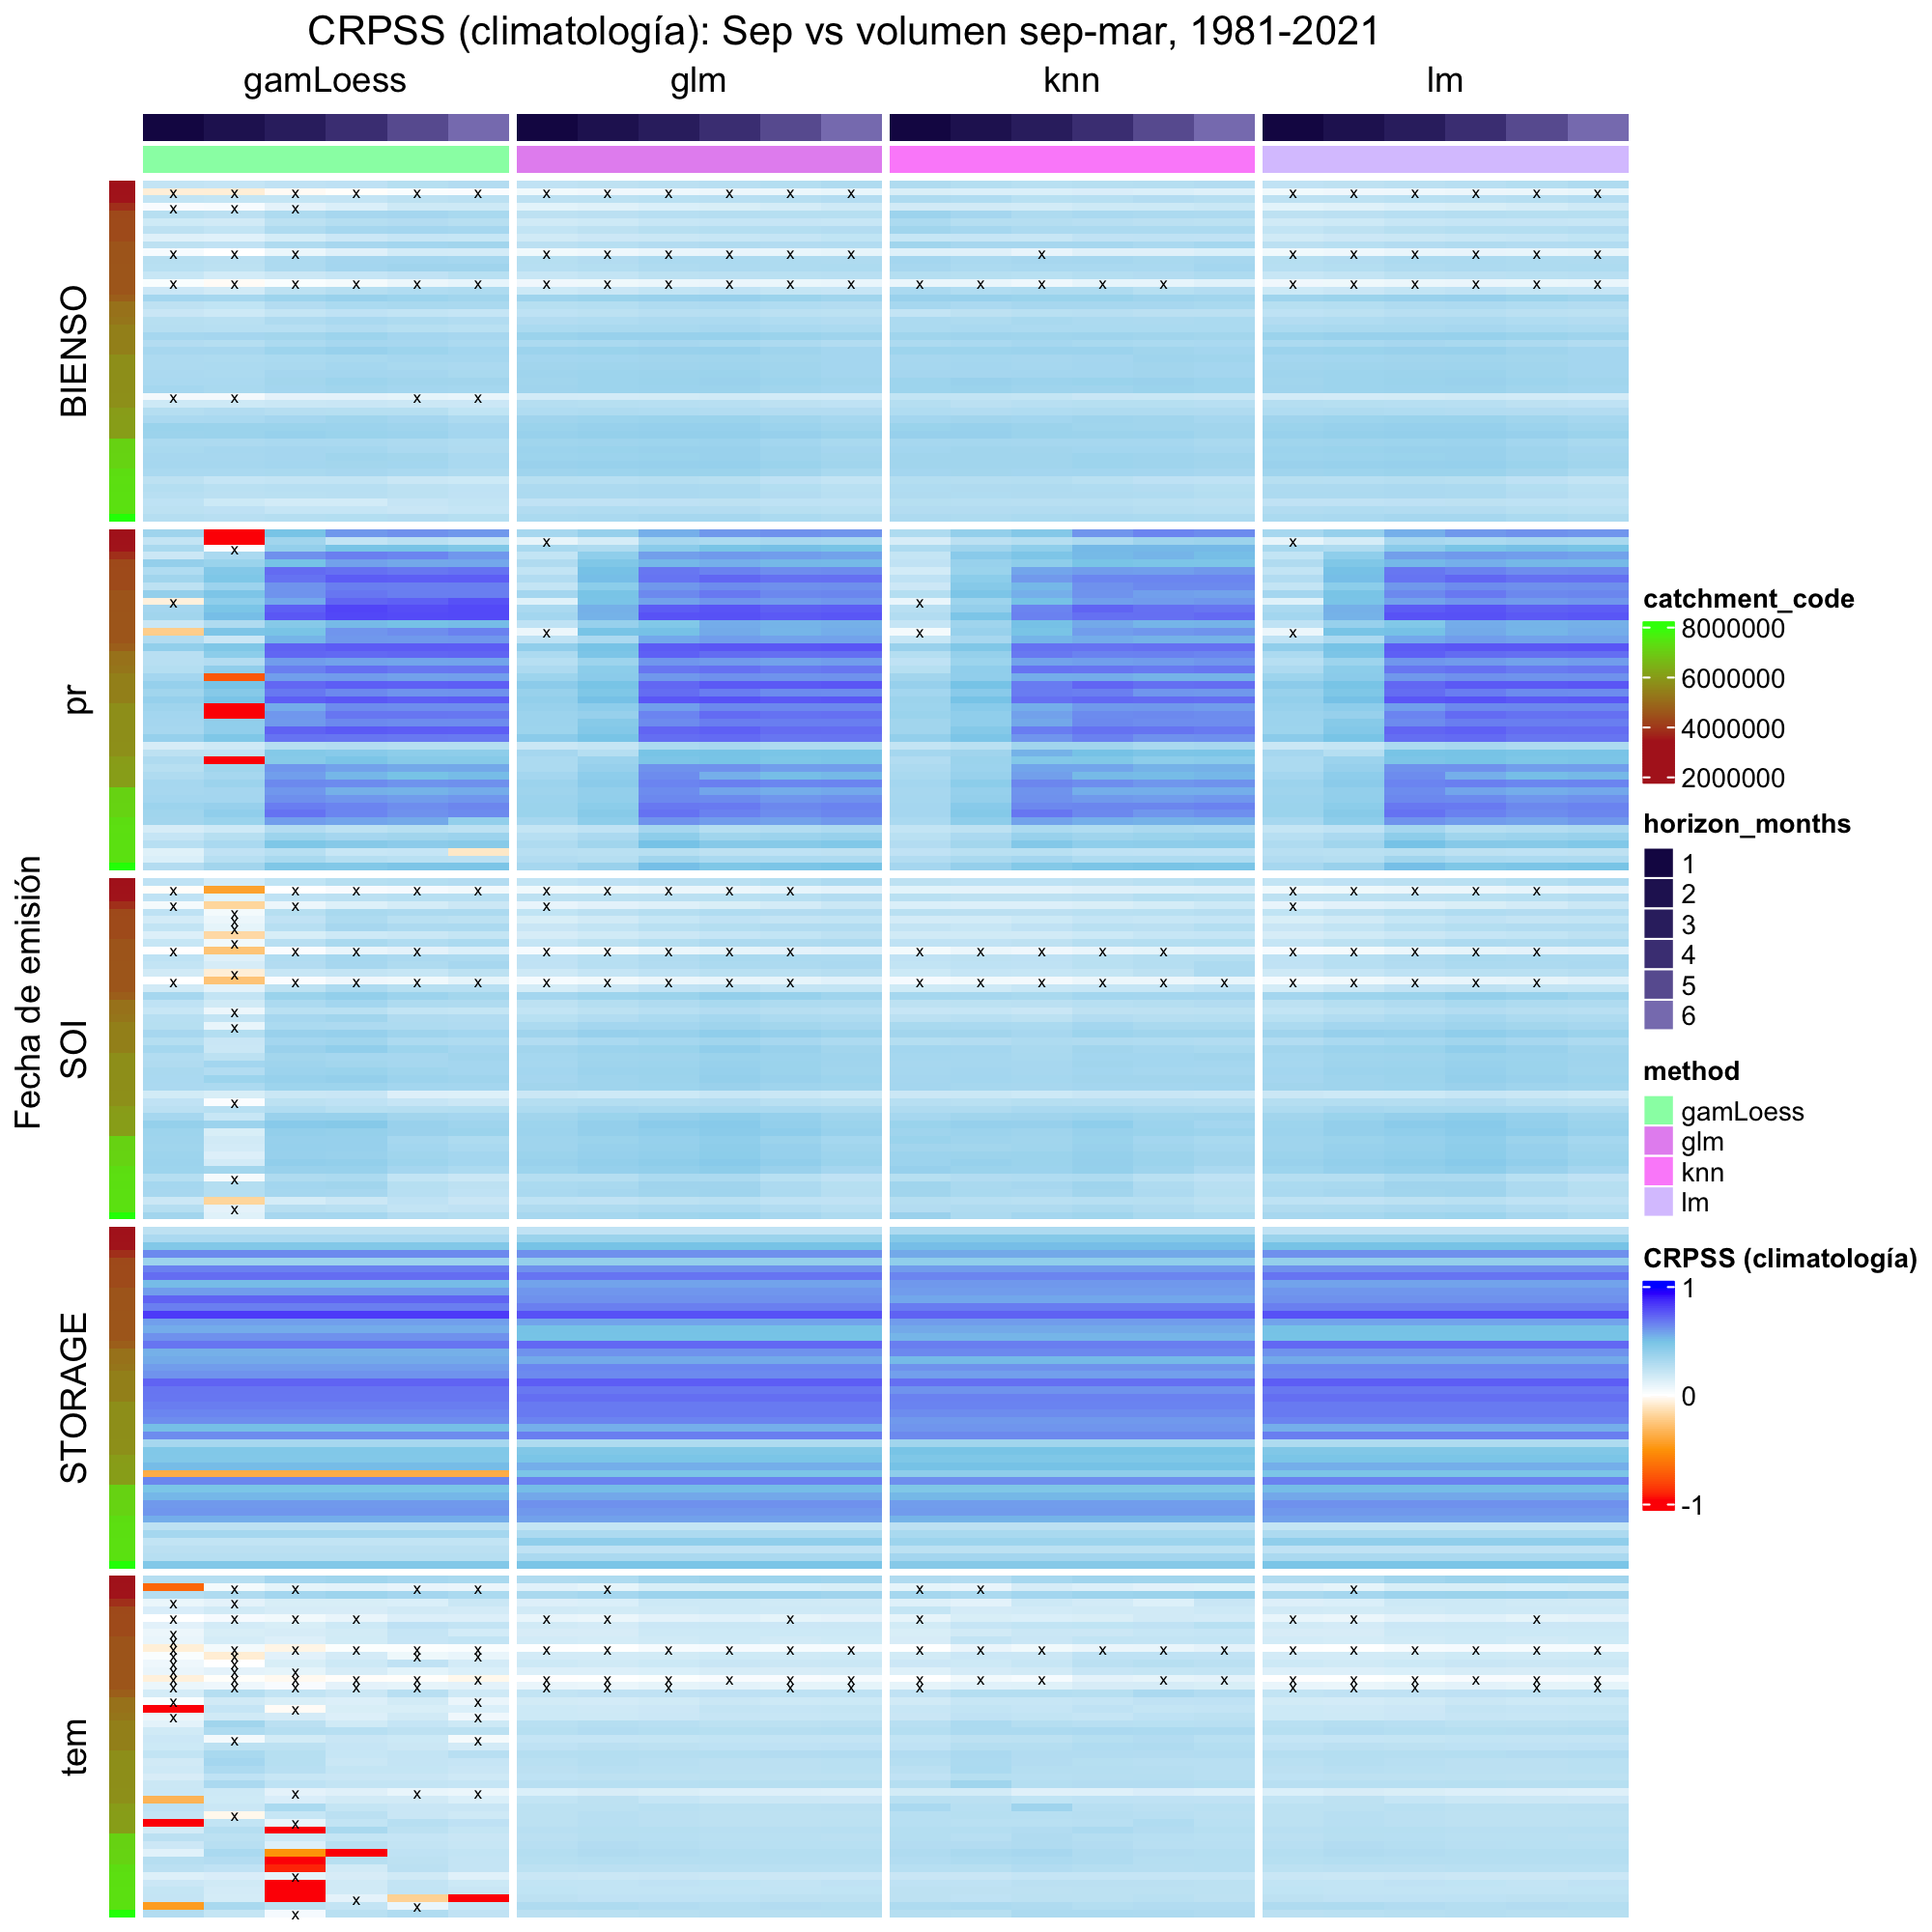

In [11]:
CRPSS_plot = list(
    filename_input  = "data_output/scores/RDS/model_results_singles_models_2023-03-14.RDS",
  metric_variable = "crpss_climatology",
  filename_export = "CRPSS_vol_indicator_pheatmap",
  legend_title = "CRPSS (climatología)",
    sub_month = "Sep",
  plot_absolute = F
)

plot = do.call(plot_pheatmap_EDA3,CRPSS_plot)
options(repr.plot.width = 10, repr.plot.height = 10,repr.plot.res = 200)
plot$plot1


In [15]:
plot_pheatmap_EDA4 <- function(
    filename_input,
    metric_variable,
    legend_title,
    filename_export,
    plot_absolute,
    threshold_for_x = 0.1
) {
  #https://jokergoo.github.io/2020/05/06/translate-from-pheatmap-to-complexheatmap/
  #https://jokergoo.github.io/ComplexHeatmap-reference/book/a-list-of-heatmaps.html
  
  library(ComplexHeatmap)
  
  df <- readRDS(filename_input)
  setDT(df)
  
  # Split predictor_name into var, fun, and horizon_months
  df <- df[, c("var", "fun", "horizon_months") := tstrsplit(predictor_list, "_", fixed = TRUE)][]
  df <- df[, horizon_months := as.numeric(gsub("*months","",horizon_months))][]
  df <- df[, horizon_months := factor(horizon_months,levels = seq(-1,12,1))]
  # Create catchment_month and predictor columns
  df <- df[, catchment_month := paste(catchment_code, month_initialisation, sep = "_")][]
  df <- df[, predictor := paste(var, horizon_months, sep = "_")]
  df$predictor = factor(df$predictor,levels = unique(df$predictor))
  # Use dcast to reshape the data into a correlation matrix
  cor_matrix <-
    dcast(df,
          catchment_month ~ predictor,
          value.var = metric_variable,
          fill = NA,
          verbose = T)
  
  # Annotation for rows
  annotation_row <- data.table(catchment_month = cor_matrix[, catchment_month])
  annotation_row <-annotation_row[,
                                  c("catchment_code", "month_initialisation") := 
                                    tstrsplit(catchment_month, "_",
                                              fixed = TRUE, keep = 1:2)]
  #annotation_row$month_initialisation = lubridate::month(as.numeric(annotation_row$month_initialisation),label = T)
  annotation_row$month_initialisation = paste0('1° ',annotation_row$month_initialisation)
  
  annotation_row <- annotation_row[, catchment_code := as.numeric(catchment_code)]
  annotation_row <- annotation_row[, month_initialisation := factor(
    x = month_initialisation,
    levels = (paste0('1° ',levels(df$month_initialisation) )))]
  annotation_row <- tibble::column_to_rownames(annotation_row, var = "catchment_month")
  rows_split <-  annotation_row$month_initialisation
  annotation_row$month_initialisation <- NULL
  
  # Annotation for columns
  cor_matrix$catchment_month <- NULL
  cor_matrix <- as.matrix(cor_matrix)
  annotation_col <- data.table(predictor = colnames(cor_matrix))
  annotation_col <- annotation_col[, c("var", "horizon_months") := tstrsplit(predictor, "_", fixed = TRUE, keep = 1:2)]
  annotation_col <- annotation_col[, horizon_months := factor(horizon_months,levels = seq(-1,12,1))]
  annotation_col <- annotation_col[, var := factor(var)]
  #setkeyv(annotation_col,c("var", "horizon_months"))
  
  
  cols_split <-  annotation_col$var
  annotation_col$var <-  NULL # remove var from legend
  annotation_col$predictor <- NULL # remove predictor from legend
  colnames(cor_matrix) <- NULL #remove row labels
  
 
  
  #### colors
  length_horizon = length(unique(as.numeric(annotation_col$horizon_months)) )
  colours_blue <- colorRampPalette(c("#190E53", "#3C3176", "#887FBC"))(length_horizon)
  
  library(circlize)
  col_fun = colorRamp2(c(-1,-0.5, 0,0.5, 1), c("red","orange", "white","skyblue", "blue"))
  
  ann_colors = list(
    catchment_code = c("firebrick", 'green'),
    horizon_months = setNames(colours_blue, unique(annotation_col$horizon_months))
  )

  
  #library(RColorBrewer)
  #Plot correlation matrix and absolute correlation matrix using pheatmap
p = 
    pheatmap((cor_matrix),
             cluster_row = F,
             cluster_cols = F,
             color = col_fun,#colorRampPalette((brewer.pal(n = 7, name = "RdBu")))(100),
             annotation_row = annotation_row,
             annotation_col = annotation_col,
             
             row_split = rows_split,
             column_split = cols_split,
             annotation_names_col = F,
             annotation_names_row = F,
             annotation_colors = ann_colors,
             heatmap_legend_param = list(
               at = c(-1, 0, 1),
               title = legend_title,
               legend_height = unit(3, "cm"),
               title_position = "topleft"
             )
             # cell_fun = function(j, i, x, y, width, height, fill) {
             #   if (cor_matrix[i, j] > -threshold_for_x &
             #       cor_matrix[i, j] < threshold_for_x)
             #     grid.text('x', x, y, gp = gpar(fontsize = 6))
             # }
    )
  #export in png format
  filename_export_png = paste0(
    "data_output/scores/figures/",
    filename_export,
    today(),
    ".png"
  )
  
  png(
    filename = filename_export_png,
    width = 10,
    height = 10,
    units = "in",
    res = 800
  )
  p_draw =
    draw(p,
       merge_legend = TRUE,
       column_title = paste0(legend_title, ": predictores vs volumen sep-mar, 1981-2021"),
       row_title = "Fecha de emisión",
       column_title_gp = gpar(fontsize = 15),
       ht_gap = unit(4, "cm"))
  
  dev.off()
  
plot_list = list(plot1 = p_draw, filename1 = filename_export_png )
  
  return(plot_list)
}



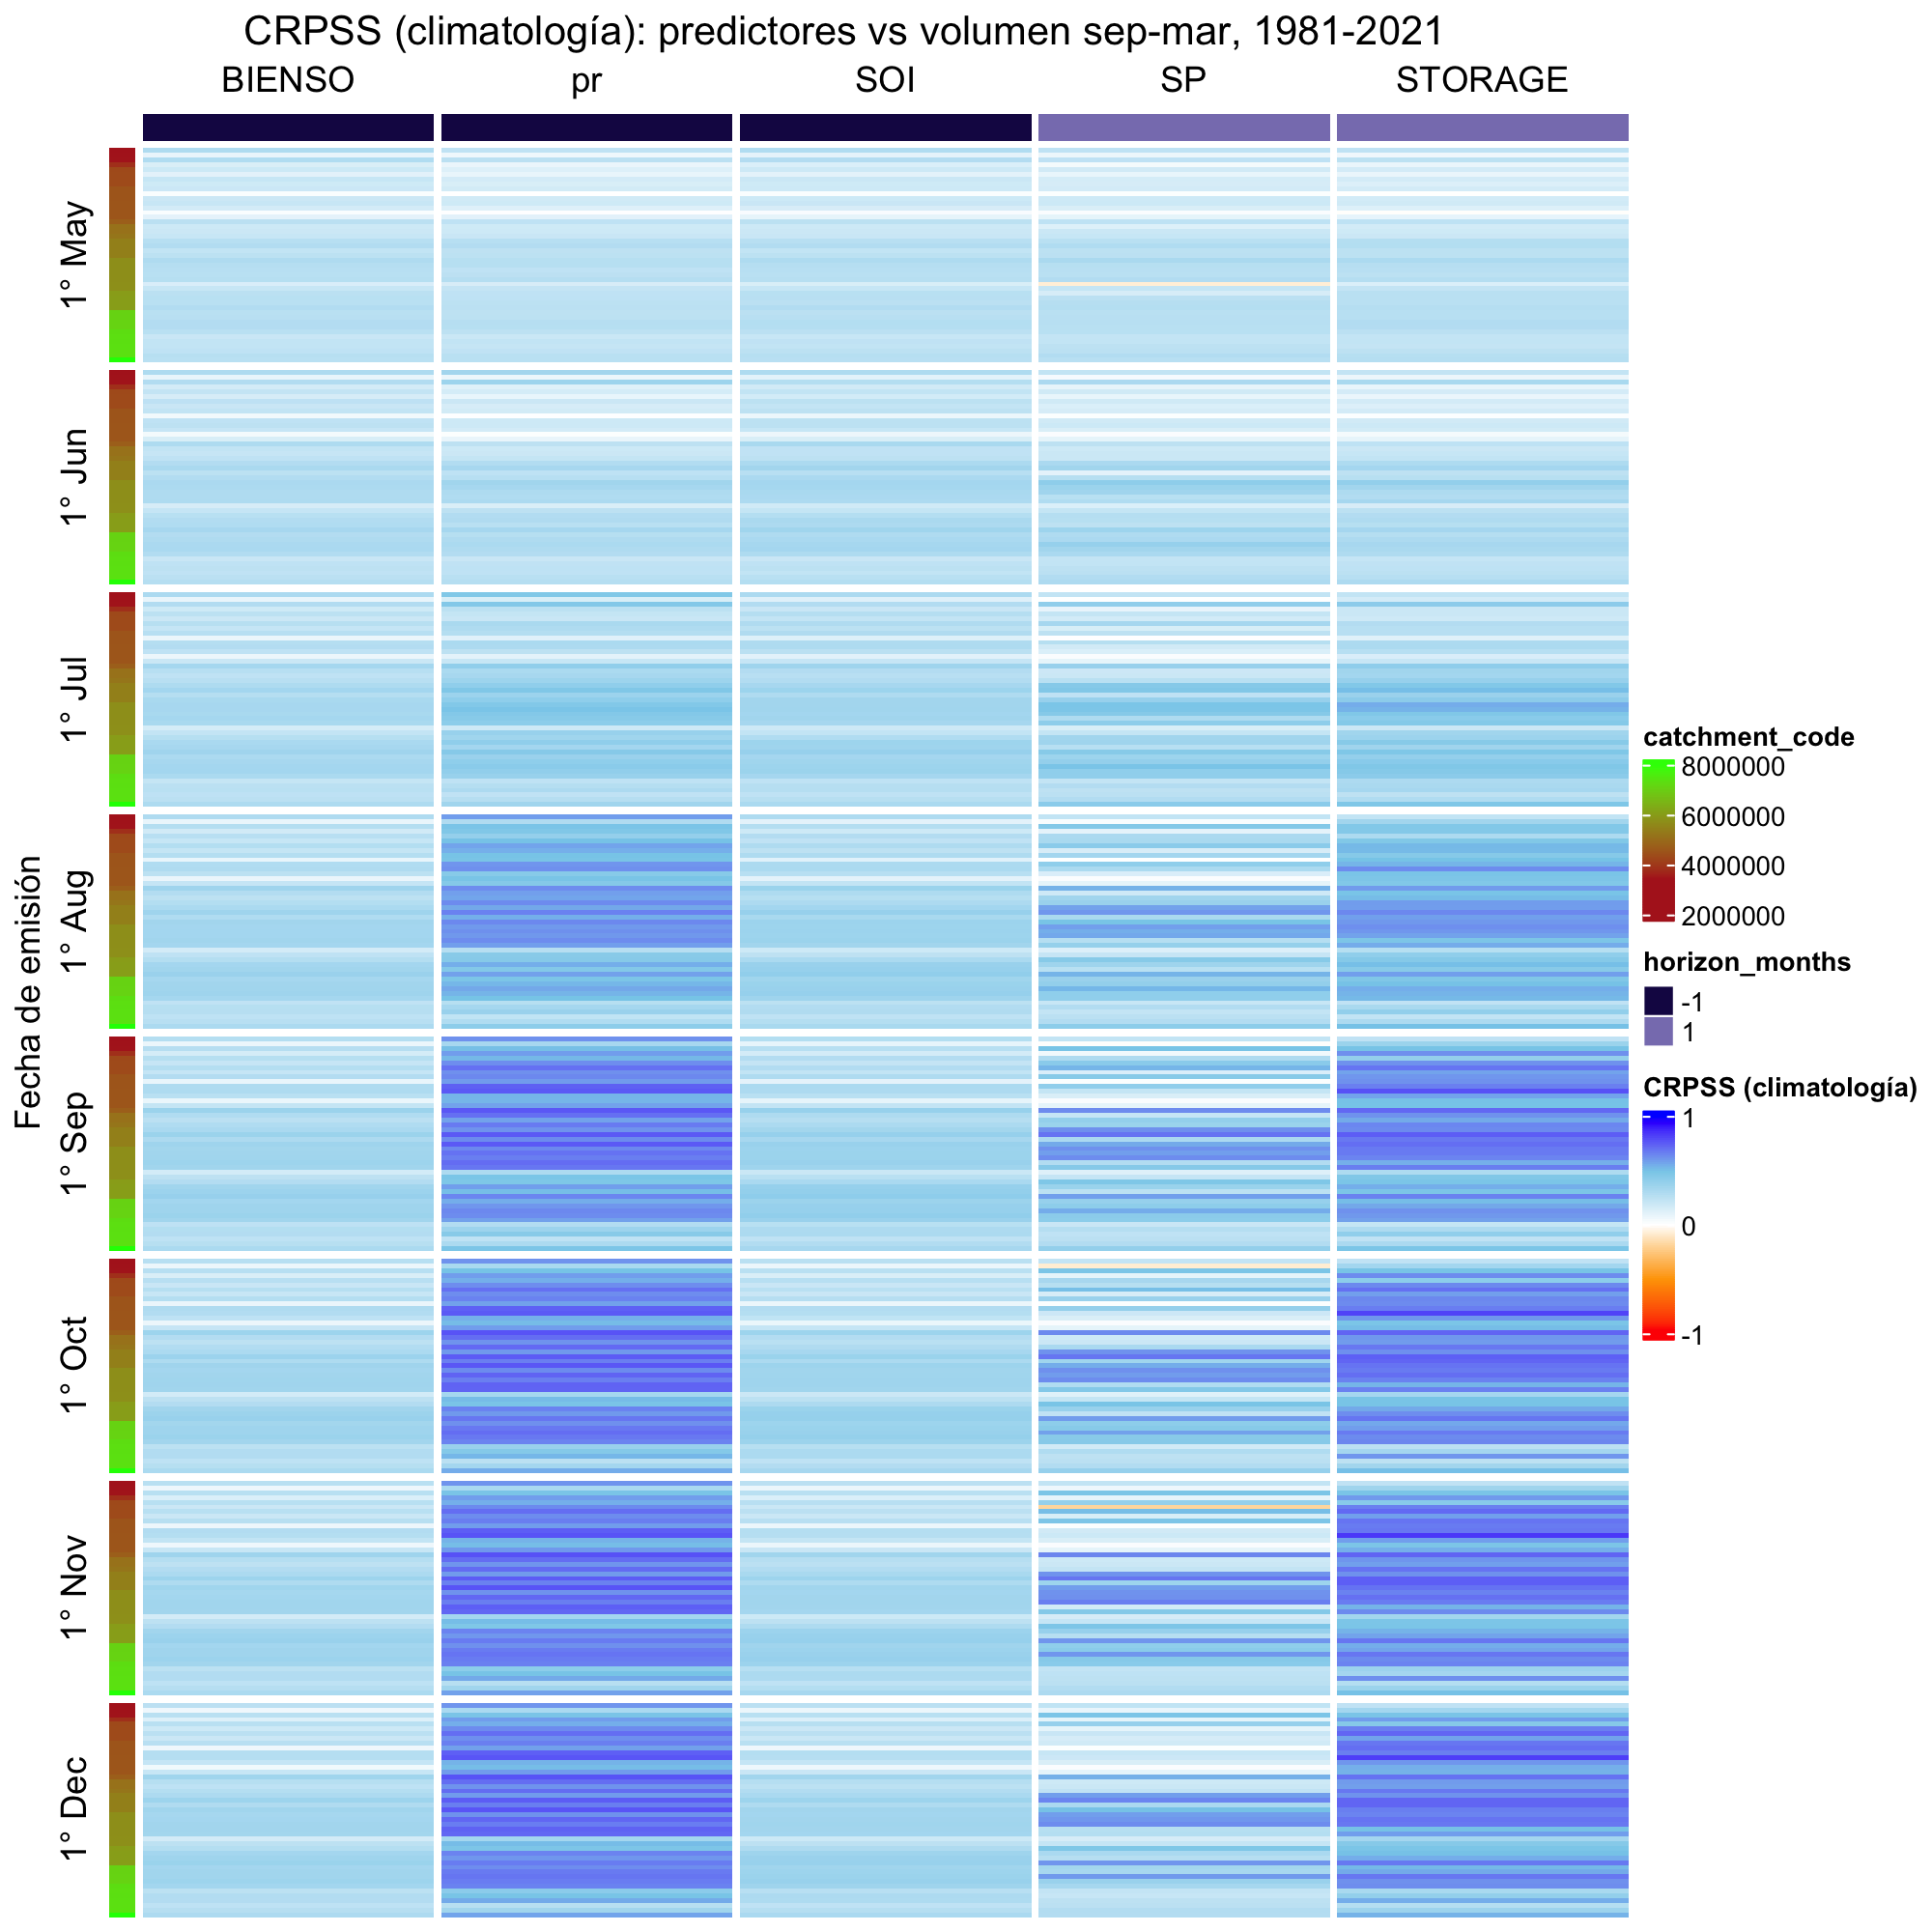

In [16]:
CRPSS_plot = list(
    filename_input  = "data_output/scores/RDS/model_results_singles_models_2023-03-15.RDS",
  metric_variable = "crpss_climatology",
  filename_export = "CRPSS_vol_indicator_pheatmap",
  legend_title = "CRPSS (climatología)",
  plot_absolute = F
)

plot = do.call(plot_pheatmap_EDA4,CRPSS_plot)

options(repr.plot.width = 10, repr.plot.height = 10,repr.plot.res = 200)
plot$plot1